In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
from astropy.constants import c
speed_of_light = c.to('km/s').value
from astropy.stats import sigma_clip

import sys
sys.path.append('/Users/jpw/py/spectools_ir/')
from spectools_ir.utils import extract_hitran_data

from astropy.io import ascii, fits
from matplotlib.gridspec import GridSpec
import pandas as pd
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# choose whether you want interactive figures or not (useful for zooming in on details but not good for the panel plot)
interactive_plot = True
if interactive_plot:
    %matplotlib widget
else:
    %matplotlib inline

### Enter date, path, source, and representative raw fits file (for metadata)

In [2]:
date = '191008'
path = '/Volumes/JPW_2TB/iSHELL/'+date+'/'
specfile = 'icm.2019B113.191008.fname.00028.a.fits'         # DRTau
specfile = 'icm.2019B113.191008.fname.00114.a.fits'         # HLTau
#specfile = 'icm.2019B113.191008.fname.00232.a.fits'         # FZTau
#specfile = 'icm.2019B113.191008.fname.00274.a.fits'         # DFTau
source = 'HLTau'
PA1 = 138
PA2 = PA1 + 180

In [3]:
date = '200220'
path = '/Volumes/JPW_2TB/iSHELL/'+date+'/'
specfile = 'icm.2020A091.200220.fname.00060.a.fits'         # DRTau
specfile = 'icm.2020A091.200220.fname.00081.a.fits'         # HLTau
specfile = 'icm.2020A091.200220.fname.00205.a.fits'         # FZTau
source = 'FZTau'
PA1 = 138
PA2 = PA1 + 180

In [4]:
date = '200221'
path = '/Volumes/JPW_2TB/iSHELL/'+date+'/'
specfile = 'icm.2020A091.200221.fname.00077.a.fits'         # DFTau
source = 'DFTau'
PA1 = 138
PA2 = PA1 + 180

In [5]:
date = '200625'
path = '/Volumes/JPW_2TB/iSHELL/'+date+'/'
specfile = 'icm.2020A091.200625.fname.00130.a.fits'         # AS205
specfile = 'icm.2020A091.200625.fname.00060.a.fits'         # RNO90
source = 'AS205'
PA1 = 34
source = 'RNO90'
PA1 = -3
PA2 = PA1 + 180

In [6]:
date = '240107'
path = '/Users/jpw/Analysis/NIRSPEC/iSHELL/'+date+'/'
#specfile = 'icm.2023B076.240106.fname.00145.a.fits'         # HL Tau
specfile = 'icm.2023B072.240107.fname.00219.a.fits'         # HL Tau
#specfile = 'icm.2023B072.240107.fname.00128.a.fits'         # CW Tau
#specfile = 'icm.2023A043.230630.fname.00036.a.fits'         # Elias 24
source = 'HLTau'
PA1 = 48
#source = 'CWTau'
#PA1 = 61

PA2 = PA1 + 180

In [7]:
table1 = pd.read_csv(path + f'reduced/{source}_flux_combined_PA{PA1}_{PA2}.csv', skipinitialspace=True)
wave_flux = table1['wavelength']
flux = table1['flux']
err_flux = table1['err_flux']
wave_min = wave_flux.min()
wave_max = wave_flux.max()

In [8]:
# calculate barycentric velocity  (https://docs.astropy.org/en/stable/coordinates/velocities.html)
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, Angle, LSR

hdu1 = fits.open(path+'raw/'+specfile)
hd = hdu1[0].header

obstime = hd['DATE_OBS']+' '+hd['TIME_OBS']
ra = hd['TCS_RA']
dec = hd['TCS_DEC']
c = SkyCoord(ra+dec, unit=(u.hourangle, u.deg))

# IRTF is close to Keck :)
keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, lon=-155.4783*u.deg, height=4160*u.m)
barycorr = c.radial_velocity_correction(obstime=Time(obstime), location=keck)  
v_bary = barycorr.to(u.km/u.s).value
print(f'Barycentric velocity = {v_bary:5.2f} km/s')
#heliocorr = c.radial_velocity_correction('heliocentric', obstime=Time(obstime), location=keck)
#print(heliocorr.to(u.km/u.s))

Barycentric velocity = -18.44 km/s


In [9]:
hitran_CO_1_0 = extract_hitran_data('CO', np.nanmin(wave_flux)-np.nanmin(wave_flux)*0.001, np.nanmax(wave_flux)+np.nanmax(wave_flux)*0.001, vup=1)
hitran_CO_2_1 = extract_hitran_data('CO', np.nanmin(wave_flux)-np.nanmin(wave_flux)*0.001, np.nanmax(wave_flux)+np.nanmax(wave_flux)*0.001, vup=2)
hitran_13CO_1_0 = extract_hitran_data('CO', np.nanmin(wave_flux)-np.nanmin(wave_flux)*0.001, np.nanmax(wave_flux)+np.nanmax(wave_flux)*0.001, isotopologue_number=2, vup=1)

hitran_CO_1_0.sort('wave')
hitran_CO_2_1.sort('wave')
hitran_13CO_1_0.sort('wave')

In [10]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)

ax.plot(wave_flux, flux, lw=1, color='b')
ax.fill_between(wave_flux, flux-err_flux, flux+err_flux, alpha=0.5, color='b')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 20, labelpad=10)
ax.set_ylabel('Flux(Jy)', fontsize = 20, labelpad=10)
#ax.set_ylim(-0.5, 0.5)
#ax.set_xlim(4.7,4.75)

# show CO v=1-0 transiions
# define a conservative region to flag the line (source and time dependent) for normalization step
# once happy with it, set flag_line to True and proceed
flag_lines = True
if flag_lines:
    flux_no_lines = flux.copy()
wflag = [-3e-4,1e-3]
for wave1 in hitran_CO_1_0['wave']:
    if ((wave1 > wave_min) & (wave1 < wave_max)):
        ax.axvline(wave1, color='lightblue', ls='-')
        iline = np.where((wave_flux > wave1+wflag[0]) & (wave_flux < wave1+wflag[1]))[0]
        if iline.size > 0:
            ax.plot(wave_flux[iline], flux[iline], color='r', alpha=0.5)
            if flag_lines:
                flux_no_lines[iline] = np.nan
                
plt.close()

In [11]:
def median_filter(arr, arr_err, w):
    # Median filter 1D array arr over a window size w in pixels

    n = arr.size
    arr_filter, arr_fiter_err = np.zeros(n), np.zeros(n)
    
    # Define the window
    for i in range(n):
        
        # Left edge
        if i<int((w-1)/2):
            arr_window = arr[:i+1+int((w-1)/2)] 
        # Central pixels
        if int((w-1)/2)<= i < int(n - (w-1)/2):
            arr_window = arr[i-int((w-1)/2):i+1+int((w-1)/2)]
        # Right edge
        if i>=int(n - (w-1)/2):
            arr_window = arr[i-int((w-1)/2):] 
            
        arr_filter[i] = np.nanmedian(arr_window)
        arr_fiter_err[i] = 1.253 * arr_err[i]/np.sqrt(arr_window.size)
    
    return arr_filter, arr_fiter_err

### normalize the spectrum

In [12]:
# first sigma clip, then apply the median filter to the clipped data
filtered_data = sigma_clip(flux_no_lines, sigma=3, maxiters=10, masked=False, axis=0, cenfunc='median', stdfunc='mad_std')

window_width = 300    # pixels 
flux_filter, flux_filter_err = median_filter(filtered_data, err_flux, window_width)
flux_norm = flux / flux_filter
err_flux_norm = err_flux / flux_filter

Text(0, 0.5, 'Flux(Jy)')

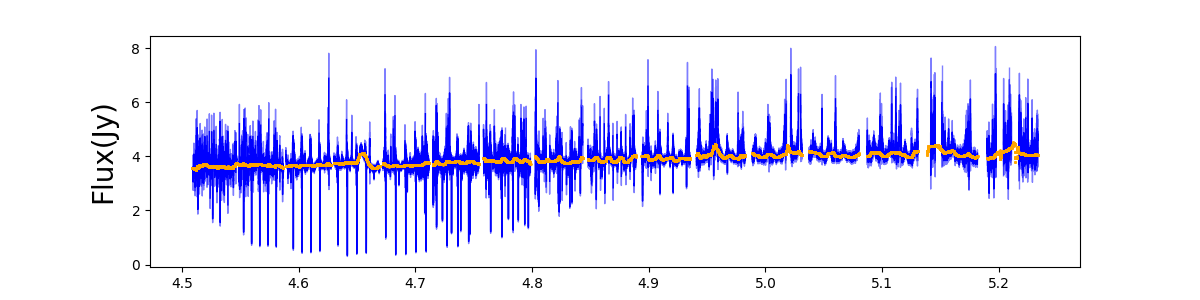

In [13]:
# check results; note that the filtering does not affect the narrow CO lines but does remove some of the Pfund beta line
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)

ax.plot(wave_flux, flux, lw=1, color='b')
ax.fill_between(wave_flux, flux-err_flux, flux+err_flux, alpha=0.5, color='b')
ax.scatter(wave_flux, flux_filter, lw=1, color='orange', zorder=2, s=1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 20, labelpad=10)
ax.set_ylabel('Flux(Jy)', fontsize = 20, labelpad=10)
#ax.set_ylim(-0.5, 0.5)
#ax.set_xlim(4.7,4.75)

Text(0, 0.5, 'Flux(Jy)')

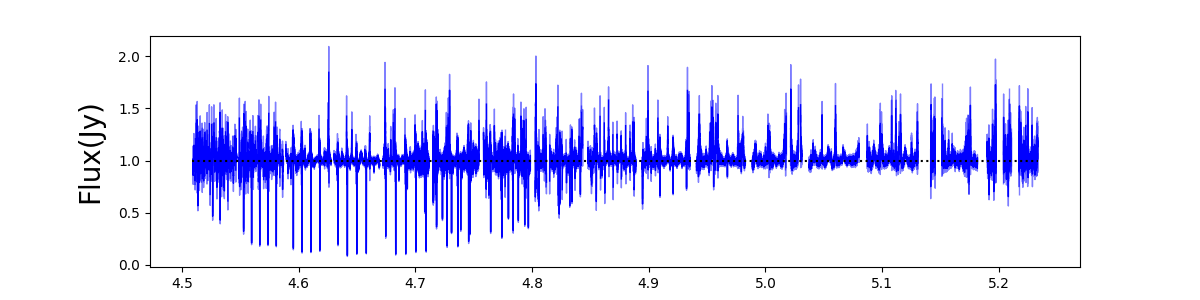

In [14]:
# plot the normalized spectrum
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)

ax.plot(wave_flux, flux_norm, lw=1, color='b')
ax.fill_between(wave_flux, flux_norm-err_flux_norm, flux_norm+err_flux_norm, alpha=0.5, color='b')
ax.plot([wave_flux.min(), wave_flux.max()], [1,1], color='black', ls=':')

# show the median filter window size
pixel_wave_size = (wave_flux.max()- wave_flux.min())/wave_flux.size
#ax.axvline(4.72, color='gray', ls='--')
#ax.axvline(4.72+window_width*pixel_wave_size, color='gray', ls='--')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 20, labelpad=10)
ax.set_ylabel('Flux(Jy)', fontsize = 20, labelpad=10)
#ax.set_ylim(-0.5, 0.5)
#ax.set_xlim(4.7,4.75)

In [15]:
# Load SA (in mas)
SA_table = pd.read_csv(path+f'rectified/{source}_SA_combined_PA{PA1}_{PA2}.csv', skipinitialspace=True)
wave_SA = SA_table['wavelength']
SA = SA_table['SA']
err_SA = SA_table['err_SA']

### Stack the CO v=1-0 transitions

In [16]:
all_transitions = []
for i in range(len(hitran_CO_1_0)):
    all_transitions.append(hitran_CO_1_0['Qpp'][i].replace(' ',''))

In [17]:
Jlow  = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8','R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8' ]
Jmid  = ['P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42']
Jhigh = ['P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42']

# Adwin's observations
Jlow  = ['P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R10', 'R11']
Jhigh = ['P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42']

In [18]:
Jstack = all_transitions
Jstack = Jlow
#Jstack = Jhigh

In [19]:
# velocity range (in telescope rest frame) for the stacked spectrum; +/- delta_v around the barycenter sampled at dv
# note that v_bary is speed toward the source
delta_v = 150
dv = 1.0
vmin = -v_bary - delta_v
vmax = -v_bary + delta_v
v_spec = np.arange(vmin, vmax+dv, dv)

# wavelength range around each transition to consider for stacking
wave0 = wave_flux.max()
delta_wave = wave0 * np.array([vmin, vmax]) / speed_of_light

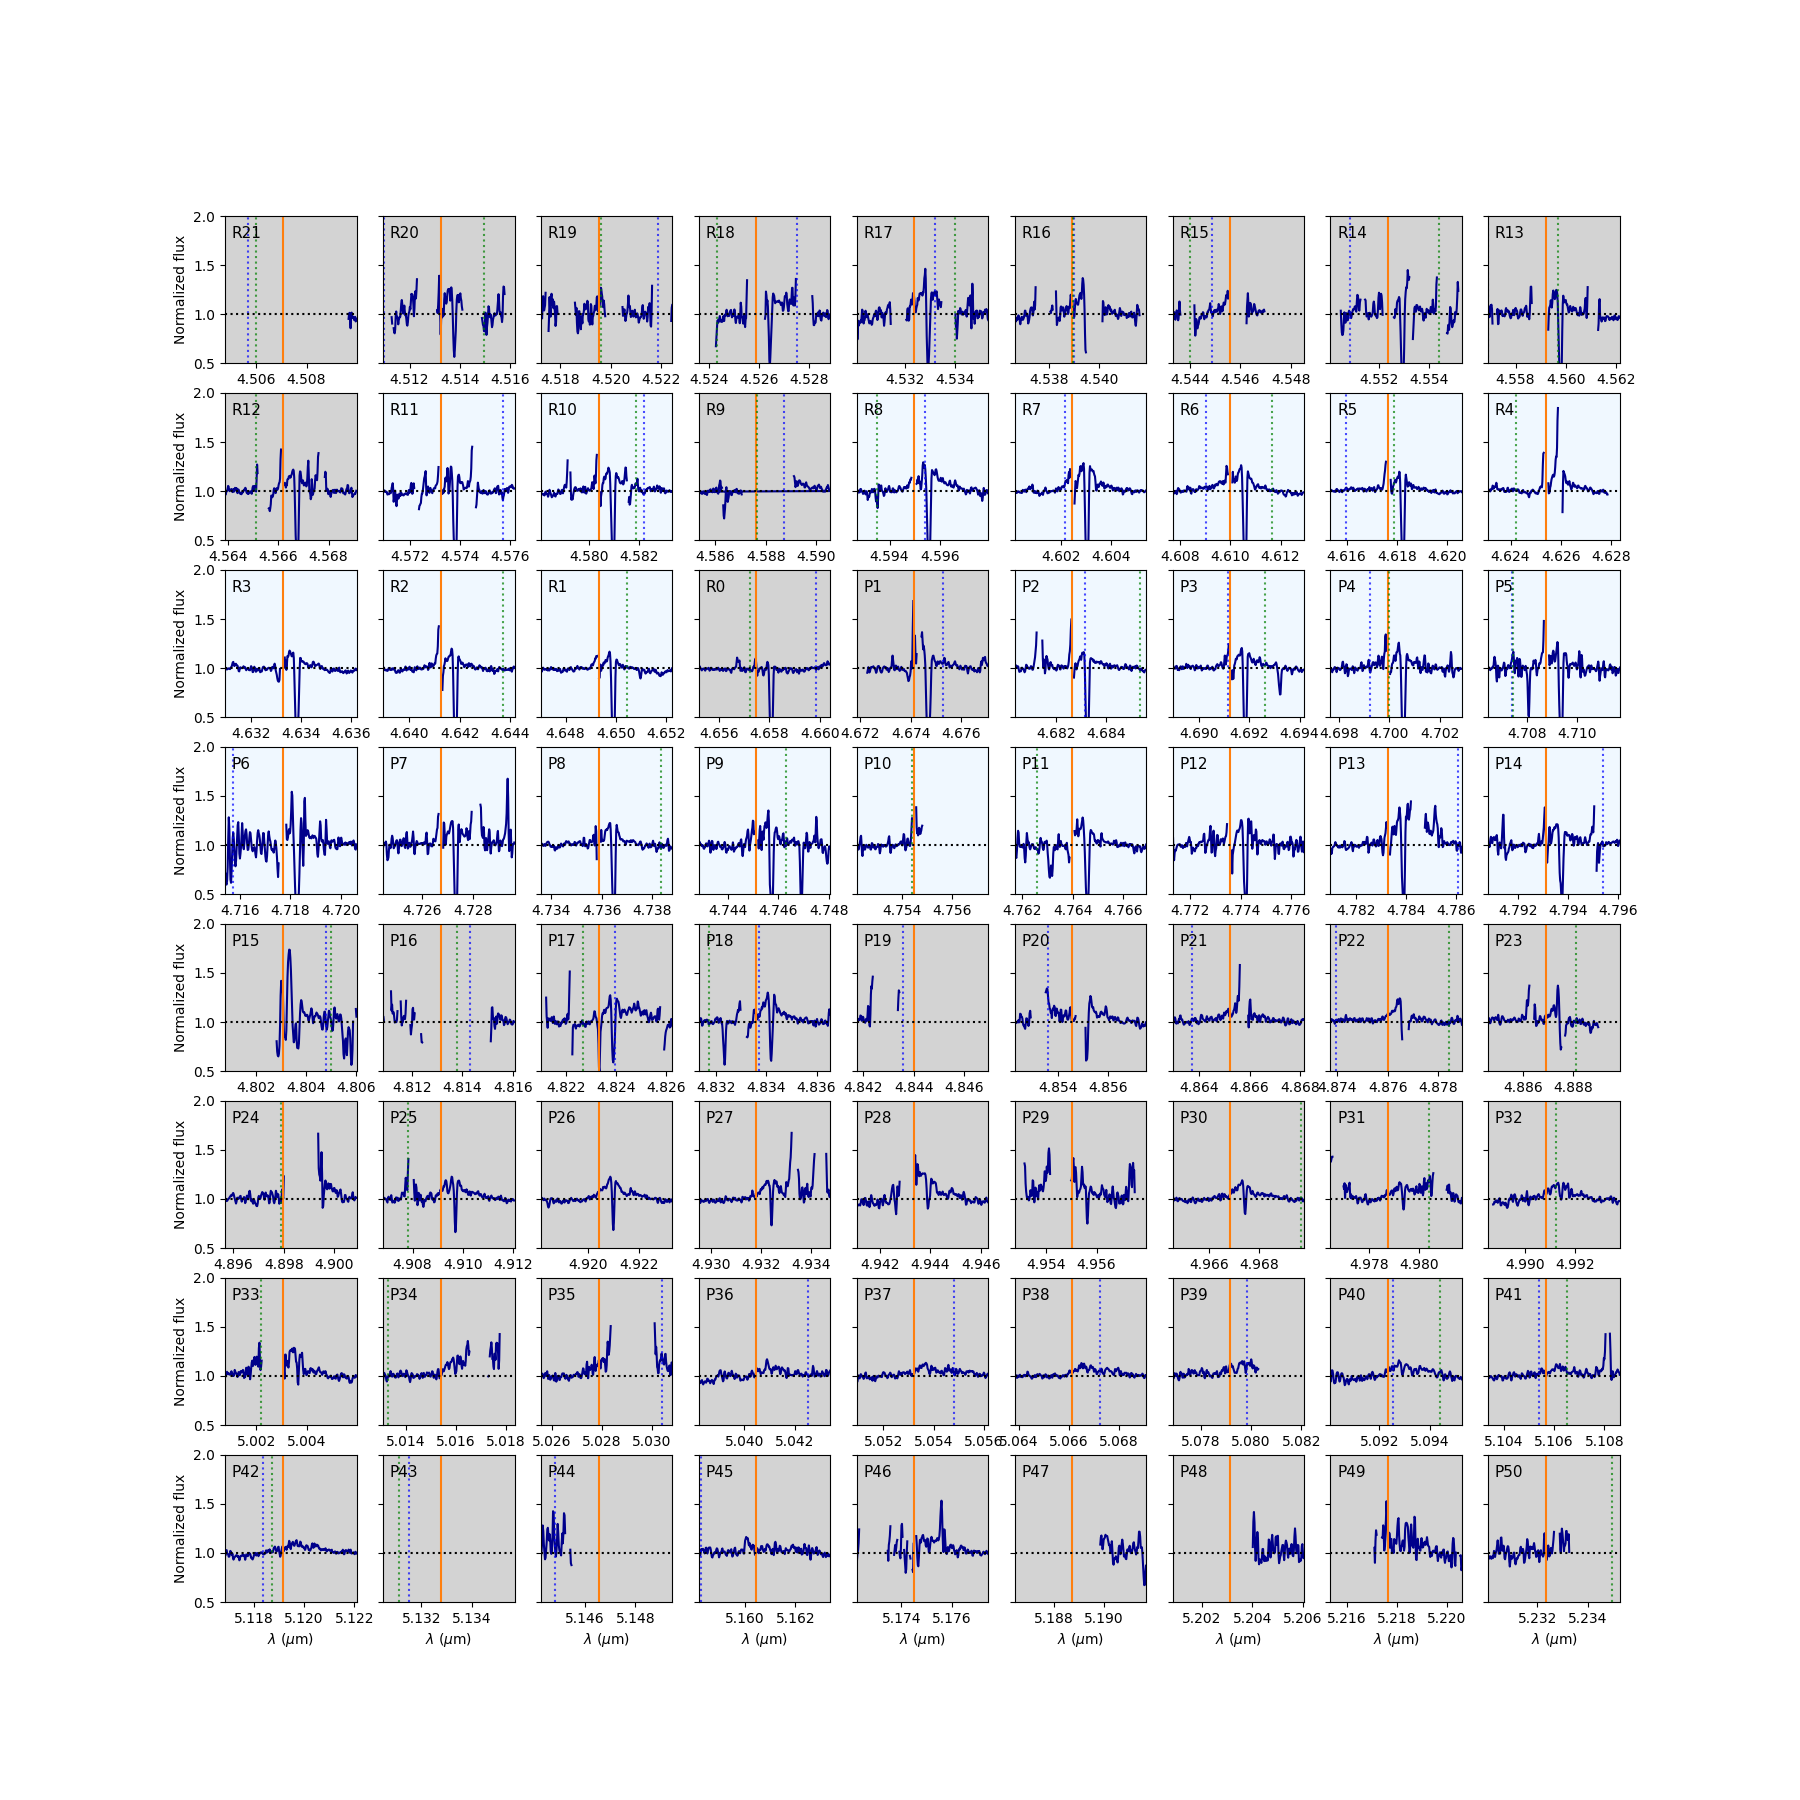

In [20]:
# plot the transitions
ymin = 0.5
ymax = 2
        
nrows = 8
ncols = math.ceil(len(hitran_CO_1_0) / nrows)
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 18))

for i, wave1 in enumerate(hitran_CO_1_0['wave']):
    col = i % ncols
    row = int(i / ncols)
    ax1 = axs[row, col]
    
    transition = hitran_CO_1_0['Qpp'][i].replace(' ','')    
    iline = np.where((wave_flux > wave1+delta_wave[0]) & (wave_flux < wave1+delta_wave[1]))[0]
    
    ax1.plot(wave_flux[iline], flux_norm[iline], color='darkblue')
    xmin = wave1+delta_wave[0]
    xmax = wave1+delta_wave[1]
    ax1.set_xlim(xmin, xmax)
    ax1.axvline(wave1, color='C1', ls = '-')
    #ax1.text(wave1+0.05*delta_wave[0], 0.6, transition, rotation=90, fontsize=10, fontweight='normal', color='C1')
    ax1.text(0.95*xmin+0.05*xmax, 0.15*ymin+0.85*ymax, transition, fontsize=11, fontweight='normal', color='black')

    # plot any CO v=2-1 transitions within delta_wave of the CO line
    for k, wave2 in enumerate(hitran_CO_2_1['wave']):
        if (wave2 > wave1+delta_wave[0]) & (wave2 < wave1+delta_wave[1]):
            ax1.axvline(wave2, color='blue', ls=':', alpha=0.7)
            #ax1.text(wave2+0.05*delta_wave[0], 0.6, hitran_CO_2_1['Qpp'][i].replace(' ',''), color='cyan', rotation=90)
                    
    # plot any 13CO v=1-0 transitions within delta_wave of the CO line
    for k, wave13 in enumerate(hitran_13CO_1_0['wave']):
        if (wave13 > wave1+delta_wave[0]) & (wave13 < wave1+delta_wave[1]):
            ax1.axvline(wave13, color='green', ls=':', alpha=0.7)
            #ax1.text(wave2+0.05*delta_wave[0], 0.6, hitran_CO_1_0['Qpp'][i].replace(' ',''), color='green', rotation=90)

    ax1.set_ylim(ymin, ymax)
    ax1.axhline(1, color='k', ls=':')
    ax1.set_xlabel(r'$\lambda$ ($\mu$m)')
    if col == 0:
        ax1.set_ylabel('Normalized flux')
    else:
        # don't show ylabels
        ax1.yaxis.set_ticklabels([])
    
    if transition in Jstack:
        ax1.set_facecolor('aliceblue')
    else:
        ax1.set_facecolor('lightgray')

# don't show axes for panels where there is no data
n_extra = nrows * ncols - len(hitran_CO_1_0)
if n_extra > 0:
    for i in range(n_extra):
        col = (nrows*ncols - i - 1) % ncols
        row = int((nrows*ncols - i - 1) / ncols)
        axs[row, col].axis('off')

#plt.savefig('transitions.png')

In [21]:
# do the actual stacking
nv = v_spec.size
flux_stack = np.zeros(nv)
flux_stack_weights = np.zeros(nv)
SA_stack = np.zeros(nv)
SA_stack_weights = np.zeros(nv)

for i, wave1 in enumerate(hitran_CO_1_0['wave']):
    transition = hitran_CO_1_0['Qpp'][i].replace(' ','')
    if transition in Jstack:
        iline = np.where((wave_flux > wave1+delta_wave[0]) & (wave_flux < wave1+delta_wave[1]))[0]
        if len(iline) == 0:
            print(f'No data for {transition}')
            sys.exit()
        vline = (wave_flux[iline] / wave1 - 1) * speed_of_light
        flux_v = interp1d(vline, flux_norm[iline], bounds_error=False)
        flux_err = interp1d(vline, err_flux_norm[iline], bounds_error=False)

        iline2 = np.where((wave_SA > wave1+delta_wave[0]) & (wave_SA < wave1+delta_wave[1]))[0]
        vline2 = (wave_SA[iline2] / wave1 - 1) * speed_of_light
        SA_v = interp1d(vline2, SA[iline2], bounds_error=False)
        SA_err = interp1d(vline2, err_SA[iline2], bounds_error=False)

        for k, v1 in enumerate(v_spec):
            f = flux_v(v1)
            e = flux_err(v1)
            if np.isfinite(f) & np.isfinite(e):
                w = 1/e**2
                flux_stack[k] = flux_stack[k] + w * f
                flux_stack_weights[k] = flux_stack_weights[k] + w

            f = SA_v(v1)
            e = SA_err(v1)
            if np.isfinite(f) & np.isfinite(e):
                w = 1/e**2
                SA_stack[k] = SA_stack[k] + w * f
                SA_stack_weights[k] = SA_stack_weights[k] + w 

flux_stack = flux_stack / flux_stack_weights
err_flux_stack = 1 / np.sqrt(flux_stack_weights)
SA_stack = SA_stack / SA_stack_weights
err_SA_stack = 1 / np.sqrt(SA_stack_weights)

/var/folders/tx/plmj8k8969gcvbqj4tml5hvm0000gn/T/ipykernel_7708/498975222.py:41: RuntimeWarning: invalid value encountered in divide
  SA_stack = SA_stack / SA_stack_weights
/var/folders/tx/plmj8k8969gcvbqj4tml5hvm0000gn/T/ipykernel_7708/498975222.py:42: RuntimeWarning: divide by zero encountered in divide
  err_SA_stack = 1 / np.sqrt(SA_stack_weights)


Text(0.5, 0.98, 'HLTau CO v=1-0 240107 P2-R11')

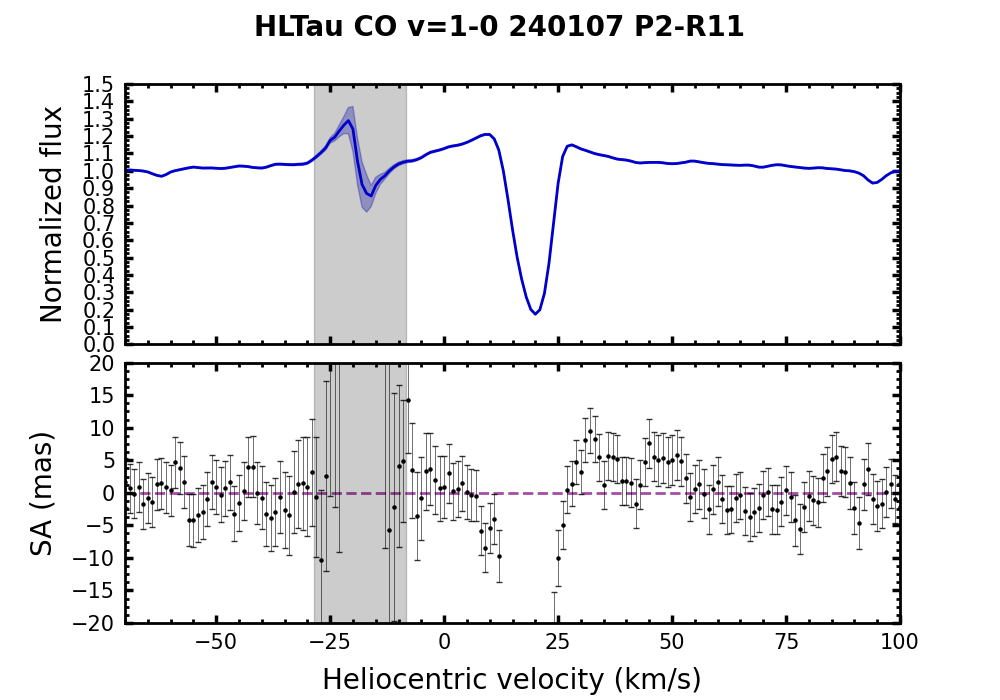

In [28]:
# plot the stacked spectrum in barycentric rest frame
fig = plt.figure(figsize=(10, 7))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.07)
ax1 = fig.add_subplot(211)
ax1.plot(v_bary+v_spec, flux_stack, color='mediumblue', lw=2)
ax1.fill_between(v_bary+v_spec, flux_stack - err_flux_stack, flux_stack + err_flux_stack, color='mediumblue', alpha=0.3)
#ax.set_xlabel('Velocity (km/s)')

ax2 = fig.add_subplot(212)
ax2.scatter(v_bary+v_spec, SA_stack, color='k', s=5)
ax2.errorbar(v_bary+v_spec, SA_stack, err_SA_stack, color='k', alpha=0.8, lw=0.5, capsize=2, linestyle=' ')
ax2.axhline(0, color='purple', ls = '--', lw=2, zorder=0, alpha=0.7)

for ax in [ax1,ax2]:
    ax.set_xlim(-70, 100)
    index_xticks = 25
    ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
    ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))
    ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=15, pad=7, width=2.5, length=6,direction='in',color='k')
    ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=15, pad=7, width=2, length=3,direction='in',color='k')
    
ax1.set_ylim(0.0, 1.5)
#ax1.set_ylim(0.9, 1.2)
index_yticks1 = 0.1 
ax1.yaxis.set_major_locator(MultipleLocator(index_yticks1))
ax1.yaxis.set_minor_locator(MultipleLocator(index_yticks1/4))

ax2.set_ylim(-20, 20)
index_yticks2 = 5
ax2.yaxis.set_major_locator(MultipleLocator(index_yticks2))
ax2.yaxis.set_minor_locator(MultipleLocator(index_yticks2/4))

ax1.set_xticklabels([])
ax2.set_xlabel('Heliocentric velocity (km/s)', labelpad=10, fontsize=20)
ax1.set_ylabel('Normalized flux', labelpad=10, fontsize=20)
ax2.set_ylabel('SA (mas)', labelpad=10, fontsize=20)

for side in ax1.spines.keys():  # 'top'
        ax1.spines[side].set_linewidth(2)
for side in ax2.spines.keys():  # 'top'
        ax2.spines[side].set_linewidth(2)
        
# gray out the telluric region
ax1.fill_between([v_bary-10, v_bary+10], 0, 2, color='black', alpha=0.2)
ax2.fill_between([v_bary-10, v_bary+10], -20, 20, color='black', alpha=0.2)
        
plt.suptitle(f'{source} CO v=1-0 {date} {Jstack[0]}-{Jstack[-1]}', fontsize=20, fontweight='bold')
#plt.savefig(path+f'reduced/{source}_stacked_PA{PA1}_{PA2}.png', bbox_inches='tight')

In [23]:
print('Writing stacked spectrum and SA signal to reduced directory')
csvfile = open(path+f'reduced/{source}_stacked_PA{PA1}_{PA2}.csv', 'w')
csvfile.write('# Stacked over transitions\n')
csvfile.write(f'#{Jstack}\n')
csvfile.write(' Vhelio,      flux,  err_flux,          SA,   err_SA\n')
for i in range(v_spec.size):
    csvfile.write(f'{v_bary+v_spec[i]:7.2f}, {flux_stack[i]:9.4f}, {err_flux_stack[i]:9.4f},    {SA_stack[i]:8.3f}, {err_SA_stack[i]:8.3f}\n')   
csvfile.close()

Writing stacked spectrum and SA signal to reduced directory


In [27]:
# check if the heliocentric velocity matches expectations for ALMA derived (LSR) value
# (note that it needs a distance but this does not affect result..?!)
# for HL Tau, V_LSR = 7.14 km/s (Yen et al. 2019)
# for CW Tau, V_LSR ~ 6 km/s (Pietu et al. 2014)
# for Elias 20, V_LSR ~ -3 km/s (DSHARP CO data)
vhelio = 20
c3 = SkyCoord(ra=Angle(ra+' hours'), dec=Angle(dec+' degrees') \
                ,pm_ra_cosdec=0*u.mas/u.yr, pm_dec=0*u.mas/u.yr \
                ,radial_velocity=vhelio*u.km/u.s, distance = 1*u.pc)
print(f'For V_helio = {vhelio} km/s,    v_LSR = {c3.transform_to(LSR()).radial_velocity:5.2f}')

For V_helio = 20 km/s,    v_LSR =  7.32 km / s
